## Task1

In [10]:
import matplotlib.pyplot as plt
from PIL import Image
from skimage import data
from skimage.transform import resize
import numpy as np
import cv2 as cv
import scipy
import time
import math
import os
import json

start_time = time.time()

def create_rectangular_filters(N=24,min_max_size=1, max_max_size=24):
    """ This function uses the five base rectangular filters and
    creates all the possible different size and position filters
    inside an N by N area. The output of this function is a list of
    dictionaries. Each dictionary represents a rectangular filter
    at a particular position (x,y) and a particular width and Height.
    Note: the value of threshold for all the filters is set to zero.
    This value is just a place holder. The value of alpha for all the
    filters is set to 1. This is just a place holder to be used for Adaboost
    Farhad Kamangar Feb. 13, 2017"""
    FeatureTypes = [(1, 2),(2, 1),(1, 3),(3, 1), (2, 2)]
    rectangular_filters = []
    for current_feature in FeatureTypes:
        for height in range(current_feature[0], N+1, current_feature[0]):
            for width in range(current_feature[1], N+1, current_feature[1]):
                if max(height,width) >= min_max_size and max(height,width) <= max_max_size:
                    for x in range(N - width+1):
                        for y in range(N - height+1):
                            temp_dict={"type":current_feature,"position":(x,y),"width":width,"height":height,"threshold":0,"alpha":1}
                            rectangular_filters.append(temp_dict)
    return rectangular_filters

'''calculating integral image'''
def integralImage(img):
    Integral_image = np.zeros((img.shape[0],img.shape[1]))
    #print(img)
    b=np.cumsum(np.cumsum((img),1),0);
    return b

'''loading images '''
def load_images(path, label):
    images = []
    for _file in os.listdir(path):
        if _file.endswith('.bmp' ) or _file.endswith(".jpg"):
            imageSrc =os.path.join(path, _file)
            img=np.array(Image.open(imageSrc).convert('L'))/255.
            images.append(img)
    return images

def get_corners(ii,startX,startY,endX,endY):
    
    if startX ==0 and startY == 0:
        value = ii[:,endY-1,endX-1]

    elif startX ==0 and startY !=0:
        temp1 =  ii[:,endY-1,endX-1]
        temp2 =  ii[:,startY-1,endX-1]
        value = temp1-temp2
    elif startX !=0 and startY ==0:
        temp1 = ii[:,endY-1,endX-1]
        temp2 = ii[:,endY-1,startX-1]
        value = temp1-temp2
    else:
        a = ii[:,startY-1,startX-1]
        b = ii[:,startY-1,endX-1]
        c = ii[:,endY-1,startX-1]
        d = ii[:,endY-1,endX-1]
        value = d-(b+c)+a
    return value
    
    
    
'''calculating haar feature value'''
def calc_haar_value(img_int,haar_type,pixelX,pixelY,haarX,haarY):
   
    ii = img_int
      

    '''pixelX and pixelY starting point of filter,haarX and haarY is the feature size'''

    
    moveX = haarX
    moveY = haarY

    #left/right white-black
    if haar_type == (1,2):
        white = get_corners(ii,pixelX,pixelY,pixelX+math.floor(moveX/2),pixelY+moveY)
        black = get_corners(ii,pixelX+math.ceil(moveX/2),pixelY,pixelX+moveX,pixelY+moveY)
        val = white-black
    
    elif haar_type == (2,1):
        white = get_corners(ii,pixelX,pixelY,pixelX+moveX,pixelY+math.floor(moveY/2))
        black = get_corners(ii,pixelX,pixelY+math.ceil(moveY/2),pixelX+moveX,pixelY+moveY)
        val = white+black

    elif haar_type == (1,3):
        white1 = get_corners(ii,pixelX,pixelY,pixelX+math.floor(moveX/3),pixelY+moveY)
        black = get_corners(ii,pixelX+math.ceil(moveX/3),pixelY,pixelX+math.floor((moveX)*(2/3)),pixelY+moveY)
        white2 = get_corners(ii,pixelX+math.ceil((moveX)*(2/3)),pixelY,pixelX+moveX,pixelY+moveY)
        val = white1 + white2 - black

    elif haar_type == (3,1):
        white1 = get_corners(ii,pixelX,pixelY,pixelX+moveX,pixelY+math.floor(moveY/3))
        black = get_corners(ii,pixelX,pixelY+math.ceil(moveY/3),pixelX+moveX,pixelY+math.floor((moveY)*(2/3)))
        white2 = get_corners(ii,pixelX,pixelY+math.ceil((moveY)*(2/3)),pixelX+moveX,pixelY+moveY)
        val = white1 + white2 - black

    elif haar_type == (2,2):
        #test =  get_corners(ii,pixelX-1,pixelY-1,pixelX+moveX,pixelY+moveY)
        #print('test: ',test)
        white1 = get_corners(ii,pixelX,pixelY,pixelX+math.floor(moveX/2),pixelY+math.floor(moveY/2))
        #print('white1: ',white1)
        black1 = get_corners(ii,pixelX+math.ceil(moveX/2),pixelY,pixelX+moveX,pixelY+math.floor(moveY/2))
        #print('black: ',black1)
        black2 = get_corners(ii,pixelX,pixelY+math.ceil(moveY/2),pixelX+math.floor(moveX/2),pixelY+moveY)
        white2 = get_corners(ii,pixelX+math.ceil(moveX/2),pixelY+math.ceil(moveY/2),pixelX+moveX,pixelY+moveY)
        #print('white2: ',white2)
        val = white1+white2-(black1+black2)
    return val


def get_threshold(h_type,width,height):

    threshold_range =None
    if h_type == (1,2):
        temp = (width*height)/2
        threshold_range = np.linspace(-temp,temp,20)
    elif h_type == (2,1):
        temp = (width*height)/2
        threshold_range = np.linspace(-temp,temp,20)
    elif h_type == (1,3):
        temp = (width*height)/3
        threshold_range = np.linspace(-temp,2*temp,20)
    elif h_type == (3,1):
        temp = (width*height)/3
        threshold_range = np.linspace(-temp,2*temp,20)
    elif h_type == (2,2):
        temp = (width*height)/2
        threshold_range = np.linspace(-temp,temp,20)
    
    return threshold_range



def train_adaboost_face_detection(T,faces_path,non_faces_path):
    rectangular_filters=create_rectangular_filters(24)                                            
    faces = load_images(faces_path,1)
    nonfaces= load_images(non_faces_path,-1)
    all_training = faces+nonfaces

    I_images_faces = []
    for i in range(0,len(all_training)):
        ii = integralImage(all_training[i])
        I_images_faces.append(ii)

    I_images_faces= np.array(I_images_faces)

    '''intializing weights'''
    weight_faces = np.ones((len(faces),1))/(2*len(faces))
    weight_gt_faces = np.ones((len(faces),1))
    weight_nonfaces = np.ones((len(nonfaces),1))/(2*len(nonfaces)) 
    weight_gt_nonfaces = np.tile(-1,(len(nonfaces),1))
    weight_all =  np.concatenate((weight_faces,weight_nonfaces), axis=0)
    weight_gt_all = np.concatenate((weight_gt_faces,weight_gt_nonfaces))

    final_faces = []

    for j  in range(0,len(rectangular_filters)):
    
        pixelX = rectangular_filters[j].get('position')[0]
        
        pixelY = rectangular_filters[j].get('position')[1]
        width = rectangular_filters[j].get('width')
        height = rectangular_filters[j].get('height')
        haar_type = rectangular_filters[j].get('type')
        faces_haar_value= calc_haar_value(I_images_faces,haar_type,pixelX,pixelY,width,height)
        final_faces.append(faces_haar_value)
        th = get_threshold(haar_type,width,height)
        thresh = np.tile(th,(len(all_training), 1))
        faces_haar_value = np.array([faces_haar_value]).T
        temp_faces=(faces_haar_value>=thresh).astype(int)
        temp_faces[temp_faces==0]=-1
        xor_result=temp_faces.copy()
        temp_weight_gt = np.tile(weight_gt_all,(1,20))
    
        xor_result[xor_result==temp_weight_gt] = 0
        xor_result[xor_result!=0]=1
        temp_weight_all = np.tile(weight_all,(1,xor_result.shape[1]))
        output = xor_result* temp_weight_all
    
        output = output.sum(axis=0)
        error =abs(output-0.5)
    
        dter_threshold= th[np.argmax(error)]
   
        rectangular_filters[j]['threshold']=dter_threshold
    


    final_faces = np.array(final_faces)    
    classifier=[]

    for i in range(0,T):
        print('iteration: ',i)
        final_error=0
        classifier_no=None
    
        error_list = []
        final_output = []
   
    
        for k in range(0,len(rectangular_filters)):
        
            
                th_value =  rectangular_filters[k].get('threshold')
                
                temp1 = np.array([((final_faces[k]>=th_value).astype(int))])
                temp1=temp1.T
                temp1[temp1==0]=-1
                xor_bw_gt=temp1.copy()
           
                xor_bw_gt[xor_bw_gt==weight_gt_all]=0
                xor_bw_gt[xor_bw_gt!=0]=1
            
    
                res = xor_bw_gt*weight_all
            
                res = res.sum(axis=0)
           
                error_list.append(res)
        
                final_output.append(temp1)
            
        
        error_list = np.array(error_list)
        temp_error_list = np.abs(error_list-0.5)
        index = np.argmax(temp_error_list)
        final_error = error_list[index]
    
    
        '''calculating alpha'''
        alpha = 0.5*np.log((1-final_error[0])/(final_error[0]))
        f_output = final_output[index]
   
    
   
        weight_all = weight_all*(np.exp(-alpha*(weight_gt_all)*f_output))
        weight_all = weight_all/(sum(weight_all))
        rectangular_filters[index]['alpha']=alpha
   
        classifier.append(rectangular_filters[index])


     
    with open('haarTrained.json ', 'w') as outfile:
        json.dump(classifier, outfile)

    print("--- %s seconds ---" % (time.time() - start_time)) 

T = 200
'''test image directory'''
test_faces = 'faces/'
test_nonfaces = 'nonfaces/'

train_adaboost_face_detection(T,test_faces,test_nonfaces)  



iteration:  0
iteration:  1
--- 11.442869901657104 seconds ---


## Task2

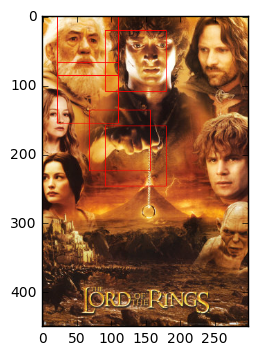

In [7]:
import matplotlib.pyplot as plt
from PIL import Image
from skimage import data
from skimage.transform import resize
import numpy as np
import cv2 as cv
import scipy
import time
import math
import os
import json
from scipy import misc


start_time = time.time()

#calculating the integral image
def integralImage(img):
    Integral_image = np.zeros((img.shape[0],img.shape[1]))
    #print(img)
    b=np.cumsum(np.cumsum((img),1),0);
    return b
def get_corners(ii,startX,startY,endX,endY):
    
    '''padding zeros at the end of rows and cols'''
    temp1= np.zeros((1,ii.shape[1]))
    ii=np.append(ii,temp1,axis=0)
    temp2=np.zeros((ii.shape[0],1))
    ii =np.append(ii,temp2,axis=1)
    
    #print(ii)
    a = ii[startY,startX]
    b = ii[startY,endX]
    c = ii[endY,startX]
    d = ii[endY,endX]
    #print("a",a)
    #print('b',b)
    #print('c',c)
    #print('d',d)
    
    intensity = d-(b+c)+a
    return intensity

'''calculating haar feature value'''
def calc_haar_value(img,haar_type,pixelX,pixelY,haarX,haarY):
    ii = img
    #print(ii)
    val=0
    '''pixelX and pixelY starting point of filter,haarX and haarY is the feature size'''

    
    moveX = haarX-1
    moveY = haarY-1
    #haar_type = har[0].get('type')
    #print(haar_type)

    #left/right white-black
    if haar_type == [1,2]:
        #test =  get_corners(ii,pixelX-1,pixelY-1,pixelX+moveX,pixelY+moveY)
        #print(test)
        white = get_corners(ii,pixelX-1,pixelY-1,pixelX+math.floor(moveX/2),pixelY+moveY)
        #print("white",white)
        black = get_corners(ii,pixelX+math.ceil(moveX/2)-1,pixelY-1,pixelX+moveX,pixelY+moveY)
        #print('black',black)
        val = white-black
        #print(val)

    elif haar_type == [2,1]:
        #print('in (2,1)')
        white = get_corners(ii,pixelX-1,pixelY-1,pixelX+moveX,pixelY+math.floor(moveY/2))
        #print("white",white)
        black = get_corners(ii,pixelX-1,pixelY+math.ceil(moveY/2)-1,pixelX+moveX,pixelY+moveY)
        #print('black',black)
        val = white+black
        #print(val)

    elif haar_type == [1,3]:
        #print('in 1,3')
        white1 = get_corners(ii,pixelX-1,pixelY-1,pixelX+math.floor(moveX/3),pixelY+moveY)
        black = get_corners(ii,pixelX+math.ceil(moveX/3)-1,pixelY-1,pixelX+math.floor((moveX)*(2/3)),pixelY+moveY)
        white2 = get_corners(ii,pixelX-1+math.ceil((moveX)*(2/3)),pixelY-1,pixelX+moveX,pixelY+moveY)
        val = white1 + white2 - black
        #print(white1 + white2 + black)

    elif haar_type == [3,1]:
         #print('in 3,1')
        white1 = get_corners(ii,pixelX-1,pixelY-1,pixelX+moveX,pixelY+math.floor(moveY/3));
        black = get_corners(ii,pixelX-1,pixelY+math.ceil(moveY/3)-1,pixelX+moveX,pixelY+math.floor((moveY)*(2/3)));
        white2 = get_corners(ii,pixelX-1,pixelY+math.ceil((moveY)*(2/3)-1),pixelX+moveX,pixelY+moveY);
        val = white1 + white2 - black

    elif haar_type == [2,2]:
        #test =  get_corners(ii,pixelX-1,pixelY-1,pixelX+moveX,pixelY+moveY)
        #print('test: ',test)
        white1 = get_corners(ii,pixelX-1,pixelY-1,pixelX+math.floor(moveX/2),pixelY+math.floor(moveY/2))
        black1 = get_corners(ii,pixelX+math.ceil(moveX/2)-1,pixelY-1,pixelX+moveX,pixelY+math.floor(moveY/2))
        black2 = get_corners(ii,pixelX-1,pixelY+math.ceil(moveY/2)-1,pixelX+math.floor(moveX/2),pixelY+moveY)
        white2 = get_corners(ii,pixelX+math.ceil(moveX/2)-1,pixelY+math.ceil(moveY/2)-1,pixelX+moveX,pixelY+moveY)
        val = white1+white2-(black1+black2)
    return val


def find_and_display_faces(test_image,data_file):
    with open(data_file) as json_file:
        data= json.load(json_file)
    #print(data)

    img_original = Image.open(test_image)
    img_copy = Image.open(test_image).convert('L')
    img_copy= np.asarray(img_copy)/255.
    #img = pil_im.resize((500,500))
    m = img_copy.shape[0]
    n = img_copy.shape[1]

    scanItr = 8
    faces = []

    #get
    intImg = integralImage(img_copy)
    #print(intImg)
    
    '''getting 24x24 window in image and sliding'''
    for itr in range(0,scanItr):
        for i in range(0,m-24,6):
            if (i + 23) > m-1 :
                break # boundary case check
            for j in range(0,n-24,6):
                if j + 23 > n-1:
                    break # boundary case check
                window = intImg[i:i+24,j:j+24]
                result = []
                for k in range(0,len(data)):
                    pixelX = data[k].get('position')[0]
                    pixelY = data[k].get('position')[1]
                    width =  data[k].get('width')
                    height = data[k].get('height')
                    haar_type=data[k].get('type')
                    threshold =data[k] .get('threshold')
                    haar_value= calc_haar_value(window,haar_type,pixelX,pixelY,width,height)
                    weight = data[k] .get('alpha')

                    if haar_value >= threshold:
                        temp =weight*1
                    else:
                        temp=weight*(-1)
                    result.append(temp)
               
                if sum(result)>0:
                    bounds = [j,i,j+23,i+23,itr];
                    faces.append(bounds)
             
        #rescaling image 
        tempImg =misc.imresize(img_copy,0.8)/255.
        img_copy = tempImg
        m = img_copy.shape[0]
        n = img_copy.shape[1]
        intImg = integralImage(img_copy);


    faceBound =np.zeros((len(faces),4));
    faces = np.array(faces)
    maxItr = max(faces[:,4])  # higher iterations have larger bounding boxes

    for i in range(0,faces.shape[0]):
        if faces[i,4] != maxItr:
            continue  #only interested in large bounding boxes
        faceBound[i,:] = (np.floor(faces[i,0:4]*(1.25**(faces[i,4]-1)))).astype(int)

    



    #print(len(faceBound))
    
    '''drawing rectangular box around detected faces'''
    for (x, y, w, h) in faceBound:
        #x = int(faceBound[0])
        x=int(x)
        #y=int(faceBound[1])
        y = int(y)
        #w =int(faceBound[2])
        w = int(w)
        #h =int(faceBound[3])
        h=int(h)
        img_original = np.array(img_original)
        cv.rectangle(img_original, (x, y), (w, h), (255, 0, 0), 1)

    plt.imshow(img_original)
    plt.show()

test_image = 'haarTrained.jpg'
data_file = 'haarTrained.json'

find_and_display_faces(test_image,data_file)